# Environment

For this exercise, I'm running a virtualenv. Installing the pre-requisites should be accomplished using:

~~~ bash
pip install -r requirements.txt
~~~

From the root directory of this project.


## File Conversion

In order to read in the files portably, the files have been converted to hdf5 using the [root2hdf5](https://github.com/HEP-DL/root2hdf5) tool.

For this exercise, a file, `chargedrec_mc7_phaseII_BGx1_KstZG.root` was provided. The file was converted to hdf5 using the command:

~~~ bash
root2hdf5 ttree chargedrec_mc7_phaseII_BGx1_KstZG.root
~~~

The output was the hdf5 file, `chargedrec_mc7_phaseII_BGx1_KstZG.h5`. Note that this requires installing root on a machine and having ROOT accessible from python.

## Import block

I was looking into recreating this in tensorflow. It looks like the layer types are a little more extensible in Keras. Since Keras uses Tensorflow as a backend by default, I'll use Keras for some exploration. Later, I can come back to tensorflow.

In [1]:
import logging
import h5py
from keras.layers import Convolution2D, MaxPooling2D  # Layer Def
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from keras.utils.io_utils import HDF5Matrix
import h5py
import numpy as np
from collections import defaultdict
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Exploring the input data

This should elucidate how data is being read out. I'm also going to use this to define which data to use as input and which data should be predicted.

For now, I'm just going to open up the file and print out the contents.

In [2]:
data_file = h5py.File('chargedrec_mc7_phaseII_BGx1_KstZG.h5','r')

In [3]:
[i for i in data_file]

[u'BtoKstG', u'BtoRhoG']

In [4]:
BtoKstG = data_file[u'BtoKstG']
BtoKstG = data_file[u'BtoRhoG']

print BtoKstG

<HDF5 dataset "BtoRhoG": shape (1107437, 478), type "<f4">


It looks like the input data has the correct shape. There were 92790 events in the original ROOT file. Due to the non-flat 4-vector momenta, I extended the fields to include 4 fields for each 4-vector. Thus the second index is a bit bigger than the number of fields in the trees in the original root file.

As a matter of convenience, I store the names of the columns in the tensors as values in the attributes field corresponding to `index<>_name`, where `<>` denotes the column number.

In [5]:
for key in BtoKstG.attrs.keys():
    print key,": ", BtoKstG.attrs[key]

index0_name :  exp_no
index1_name :  run_no
index2_name :  evt_no
index3_name :  nECLClusters
index4_name :  nNeutralECLClusters
index5_name :  nChargedECLClusters
index6_name :  nGoodNeutralECLClusters
index7_name :  neutralECLEnergy
index8_name :  chargedECLEnergy
index9_name :  goodNeutralECLEnergy
index10_name :  nTracks
index11_name :  nMCParticles
index12_name :  nParticles
index13_name :  B0_nROETracks
index14_name :  B0_nROEECLClusters
index15_name :  B0_nGoodROEClusters
index16_name :  B0_nROEKLMClusters
index17_name :  B0_deltae
index18_name :  B0_mbc
index19_name :  B0_ThrustB
index20_name :  B0_ThrustO
index21_name :  B0_CosTBTO
index22_name :  B0_CosTBz
index23_name :  B0_R2
index24_name :  B0_cc1
index25_name :  B0_cc2
index26_name :  B0_cc3
index27_name :  B0_cc4
index28_name :  B0_cc5
index29_name :  B0_cc6
index30_name :  B0_cc7
index31_name :  B0_cc8
index32_name :  B0_cc9
index33_name :  B0_mm2
index34_name :  B0_et
index35_name :  B0_hso00
index36_name :  B0_hso01
i

## Input and prediction data description

The idea here is that I'm not sure how I'm going to define which fields are "measured" data, be they mc or real data, and which fields are "truths" or "labels". So, what I'd like to do is, for now, define a rank-2 list in python with the corresponding keys to each of the fields. In a couple steps, when I define the data generator, I can use these to stitch together the input matrix for the network.

Obviously, this can be done better by preparing the data in file more sensibly, but this is proof of concept, so I'm less worried about efficiency or elegence.

In [6]:
input_data_desc=[
    ['B0_R2','B0_CosTBTO'],
    ['B0_KST0_pi__piid','B0_KST0_K__piid'],
    ['B0_KST0_K_P','B0_KST0_pi_P'],
    ['nTracks','B0_gamma_clusterE9E25'],
    ['nGoodNeutralECLClusters','B0_gamma_CosTBTO'],
    ['B0_KST0_K_d0','B0_KST0_K_z0'],
    ['B0_KST0_pi_d0','B0_KST0_pi_z0'],
]

output_data_desc=['B0__isSignal']

In [7]:
class B2DataGenerator(object):
    """
        TODO: This can and should be threaded out as a prefetching routine.
    """
    batch_size = 100
    logger = logging.getLogger("b2.data")
    def __init__(self, datapath, dataset, input_data_desc, output_data_desc):
        self.logger.info("Assembling DataSet")
        self._file = h5py.File(datapath,'r')
        self._dataset = self._file[dataset]
        
        self._data_desc=input_data_desc
        self.output_data_desc = output_data_desc
        
        #book keeping
        self.current_index=0

        # This is put here
        self.indices=[]
        self.prediction_index = -1
        for row in self._data_desc:
            for col in row:
                for key in self._dataset.attrs:
                    if self._dataset.attrs[key] == col:
                        self.indices.append(int(key.split('x')[1].split('_')[0]))
                    elif self._dataset.attrs[key] == self.output_data_desc[0]:
                        self.prediction_index = int(key.split('x')[1].split('_')[0])        
        
    def output(self):
        """
            Returns an input layer with the appropriate shape to
            match the data that we're using.
        """
        return Input(shape=(len(self._data_desc),len(self._data_desc[0]),1))

    def __len__(self):
        """
        This assumes all of the data is stored in rows
        """
        return self._dataset.shape[0]

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        """
            Fetches out the next batch of data frames
            
            Note that there's a fun error here where if you over-optimize this
            function, it initiates a race condition on the CPU. Ask kwierman to submit 
            a ticket to fchollett.
        """
        batch = self._dataset[self.current_index:self.current_index+self.batch_size]
        data = batch[:, tuple(self.indices)]
        data = data.reshape( (self.batch_size,len(self._data_desc),len(self._data_desc[0]),1) )
        prediction = np.zeros(shape=(len(batch[:, self.prediction_index]),1))
        prediction[:,0] = batch[:, self.prediction_index]
        self.current_index+=self.batch_size
        return (data, prediction)

In [8]:
BtoKstG_datagen = B2DataGenerator('chargedrec_mc7_phaseII_BGx1_KstZG.h5','BtoKstG',input_data_desc, output_data_desc)

# Model Definition

For this excercise, I'm using vgg since it's a fairly lightweight network. I also had this prepped from an earlier study, so extending it to work for this data should be easy

In [9]:
class VGG16(Model):
    logger = logging.getLogger('b2.vgg16')
    def __init__(self, input_data,loss='binary_crossentropy'):
        self._input = input_data
        self.logger.info("Assembling Model")

        self.logger.debug("Input Shape: {}".format(self._input))

        # Block 1
        layer = Convolution2D(64, 2, 2, activation='relu', border_mode='same', 
                              name='block1_conv1')(self._input)
        layer = Convolution2D(64, 2, 2, activation='relu', border_mode='same', 
                              name='block1_conv2')(layer)
        layer = MaxPooling2D((2, 1), strides=(1, 1), name='block1_pool')(layer)

        # Block 2
        layer = Convolution2D(128, 2, 1, activation='relu', border_mode='same', 
                              name='block2_conv1')(layer)
        layer = Convolution2D(128, 1, 2, activation='relu', border_mode='same', 
                              name='block2_conv2')(layer)
        layer = MaxPooling2D((2, 1), strides=(1, 1), name='block2_pool')(layer)


        # Classification block
        layer = Flatten(name='flatten')(layer)
        layer = Dense(256, activation='relu', name='fc1')(layer)
        layer = Dense(256, activation='relu', name='fc2')(layer)
        layer = Dense(2, activation='softmax', name='predictions')(layer)

        super(VGG16, self).__init__(self._input, layer)
        self.logger.info("Compiling Model")
        self.compile(loss=loss, optimizer='sgd', metrics=['accuracy'])

## Modifying the loss function

Previously, we were using binary crossentropy as the loss function. Now, we'd like to motivate loss by physics.

Below is an example of a loss function implementing 

In [10]:
_EPSILON = K.epsilon()

def loss_tensor(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

def loss_np(y_true, y_pred):
    y_pred = np.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))
    return np.mean(out, axis=-1)

# Training!

In [11]:
logging.basicConfig(level=logging.ERROR)
model = VGG16(BtoKstG_datagen.output(), loss="sparse_categorical_crossentropy")


Epoch 1/1000
100/100 [==============================] - 0s - loss: 0.6855 - acc: 0.7100
Epoch 2/1000
100/100 [==============================] - 0s - loss: 0.6739 - acc: 0.7000
Epoch 3/1000
100/100 [==============================] - 0s - loss: 0.6682 - acc: 0.7000
Epoch 4/1000
100/100 [==============================] - 0s - loss: 0.6526 - acc: 0.7700
Epoch 5/1000
100/100 [==============================] - 0s - loss: 0.6440 - acc: 0.7300
Epoch 6/1000
100/100 [==============================] - 0s - loss: 0.6257 - acc: 0.7400
Epoch 7/1000
100/100 [==============================] - 0s - loss: 0.6448 - acc: 0.6700
Epoch 8/1000
100/100 [==============================] - 0s - loss: 0.6288 - acc: 0.6900
Epoch 9/1000
100/100 [==============================] - 0s - loss: 0.6319 - acc: 0.6700
Epoch 10/1000
100/100 [==============================] - 0s - loss: 0.6114 - acc: 0.7300
Epoch 11/1000
100/100 [==============================] - 0s - loss: 0.6194 - acc: 0.7000
Epoch 12/1000
100/100 [=======

In [ ]:
training_output = model.fit_generator(BtoKstG_datagen, samples_per_epoch = 1000, 
                                      nb_epoch=1000)

Epoch 1/1000
1000/1000 [==============================] - 0s - loss: 0.4685 - acc: 0.7600      200/1000 [=====>........................] - ETA: 0s - loss: 0.4867 - acc: 0.7500
Epoch 2/1000
1000/1000 [==============================] - 0s - loss: 0.4671 - acc: 0.7590     

In [18]:
model.save("trained_weights.h5")


## Training Metrics

Given the training output, you can plot some of the metrics inline. For instance, here is the loss history plotted. 

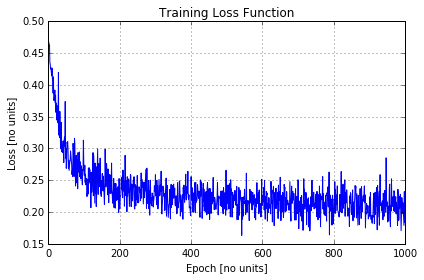

In [25]:
plt.figure()
plt.plot(training_output.epoch, training_output.history['loss'])
plt.title("Training Loss Function")
plt.xlabel("Epoch [no units]")
plt.ylabel("Loss [no units]")
plt.grid(True)
plt.tight_layout()
plt.show()

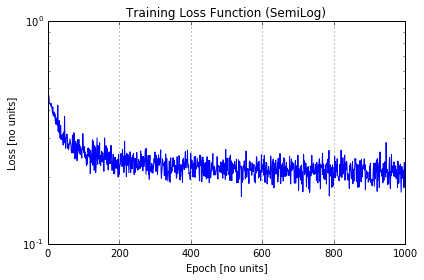

In [26]:
plt.figure()
plt.semilogy(training_output.epoch, training_output.history['loss'])
plt.title("Training Loss Function (SemiLog)")
plt.xlabel("Epoch [no units]")
plt.ylabel("Loss [no units]")
plt.grid(True)
plt.tight_layout()

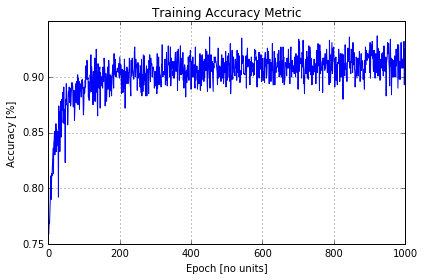

In [27]:
plt.figure()
plt.plot(training_output.epoch, training_output.history['acc'] )
plt.title("Training Accuracy Metric")
plt.xlabel("Epoch [no units]")
plt.ylabel("Accuracy [%]")
plt.grid(True)
plt.tight_layout()
plt.show()